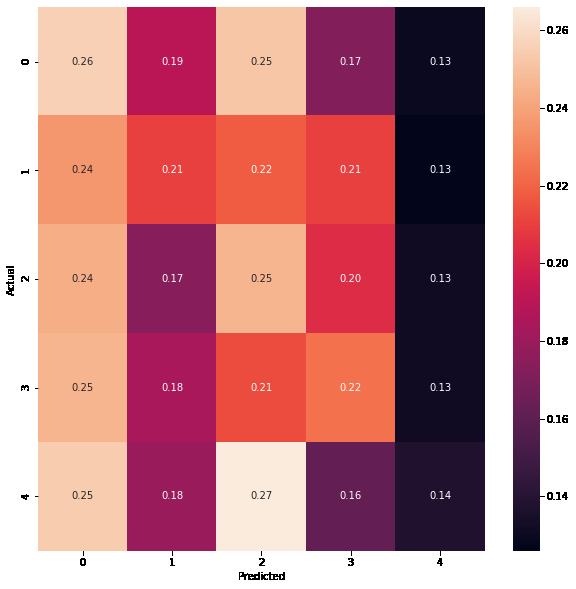

In [9]:
def load_image(input_path: str, output_format: 'str' = 'Image'):
    img = None
    try:
        img = Image.open(input_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
    except (OSError, IOError):
        print(f'Opening image failed: \n {traceback.format_exc()}')
    if output_format == 'array':
        return np.array(img)
    elif output_format == 'Image':
        return img

image_path = r'F:\Drive\School\UvA\IS - Data Science\Thesis\assets\conf_matrix_0362.png'
img_ = load_image(image_path)
img_

In [1]:
import cv2
import skimage.measure
from skimage.filters import sobel
import SimpleITK as sitk
from pybdm import BDM
import numpy as np
from PIL import Image
from cv2 import imread
from radiomics import featureextractor
import traceback
import typing
import sys
import attr
from icecream import ic
# The cpbd module tries to import scipy.ndimage.imread, which does not exist in current versions of scipy. The statement below is a workaround for this issue.
# noinspection PyTypeChecker
sys.modules['scipy.ndimage.imread'] = cv2.imread
import cpbd

In [19]:
# I'm using attrs wrongly, but it works...

# Define lists of bins for the function that calculates the K complexity feature
# TODO: make the binning user configurable
bins_0_252 = list(range(0, 252, 28))
bins_0_0_9 = list(np.arange(0, 0.9, 0.1))

full_feature_list = [
    'contrast_rms',
    'contrast_tenengrad',
    'fractal_dimension',
    'sharpness',
    'sharpness_laplacian',
    'colorfulness',
    'pixel_intensity_mean',
    'hue_mean',
    'saturation_mean',
    'k_complexity',
    'entropy_shannon',
    'pyradiomics_features'
    ]

@attr.s
class FeatureExtractor:
    str_iterable_validator = attr.validators.instance_of(typing.Iterable[str])
    # TODO: Expose all pyradiomics settings to pass through
    pyradiomics_config: dict = {'voxelBatch': 100}
    enabled_features = attr.ib(default='all')
    other_config: dict = {
        'number_of_fractal_dimension_scales': 10,
        'extract_lab_channels': True,
        'extract_rfb_channels': True
    }
    auto_color_convert: typing.Type[int] = True
    # TODO: allow finegrained enabling of pyradiomics features, instead of by class
    pyradiomics_feature_classes: str_iterable_validator = ['firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
    extracted_features: dict = {}

    _cv2_img = None
    _cv2_img_bw = None
    _cv2_img_hsv = None
    _cv2_img_lab = None
    _PIL_img = None
    _PIL_img_bw = None
    img_path = None
    fractal_dimension_scales = np.logspace(
        start=0.01,
        stop=1,
        num=other_config['number_of_fractal_dimension_scales'],
        endpoint=False,
        base=2)

    # Initialize and configure Pyradiomics feature extractor
    pyradiomics_extractor = featureextractor.RadiomicsFeatureExtractor()
    pyradiomics_extractor.settings.update(pyradiomics_config)
    pyradiomics_extractor.disableAllFeatures()
    for feature_class in pyradiomics_feature_classes:
        pyradiomics_extractor.enableFeatureClassByName(feature_class)

    @property
    def enabled_features_list(self):
        if self.enabled_features == 'all' or self.enabled_features is None:
            self.enabled_features = full_feature_list
        return self.enabled_features

    @property
    def PIL_img(self):
        if self._PIL_img is None:
            try:
                self._PIL_img = Image.open(self.img_path)
                return self._PIL_img
            except (OSError, IOError):
                print(f'Opening image at {self.img_path} failed: \n {traceback.format_exc()}')
        else:
            return self._PIL_img

    @property
    def PIL_img_bw(self):
        if self._PIL_img_bw is None:
            self._PIL_img_bw = self.PIL_img.convert('L')
        return self._PIL_img_bw

    @property
    def cv2_img(self):
        if self._cv2_img is None:
            try:
                self._cv2_img = imread(self.img_path)
                return self._cv2_img
            except (OSError, IOError):
                print(f'Opening image at {self.img_path} failed: \n {traceback.format_exc()}')
        else:
            return self._cv2_img

    @property
    def cv2_img_bw(self):
        if self._cv2_img_bw is None:
            self._cv2_img_bw = cv2.cvtColor(self.cv2_img, cv2.COLOR_BGR2GRAY)
        return self._cv2_img_bw

    @property
    def cv2_img_hsv(self):
        if self._cv2_img_hsv is None:
            self._cv2_img_hsv = cv2.cvtColor(self.cv2_img, cv2.COLOR_BGR2HSV)
        return self._cv2_img_hsv

    @property
    def cv2_img_lab(self):
        if self._cv2_img_lab is None:
            self._cv2_img_lab = cv2.cvtColor(self.cv2_img, cv2.COLOR_BGR2Lab)
        return self._cv2_img_lab

    def extract(self, img_path):
        self.img_path = img_path
        self.extracted_features.update({'img_path': self.img_path})
        extractor_mapping = {
            'contrast_rms': self.contrast_rms,
            'contrast_tenengrad': self.contrast_tenengrad,
            'fractal_dimension': self.fractal_dimension,
            'sharpness': self.sharpness,
            'sharpness_laplacian': self.sharpness_laplacian,
            'colorfulness': self.colorfulness,
            'pixel_intensity_mean': self.pixel_intensity_mean,
            'saturation_mean': self.saturation_mean,
            'hue_mean': self.hue_mean,
            'entropy_shannon': self.entropy_shannon,
            'k_complexity': self.k_complexity,
            'pyradiomics_features': self.pyradiomics_features
        }
        # Call all enabled feature extractors
        for extractor in extractor_mapping:
            if extractor in self.enabled_features_list:
                ic(extractor)
                extractor_mapping[extractor]()

    def contrast_rms(self):
        feature_value = self.cv2_img_bw.std()
        self.extracted_features.update({'contrast_rms': feature_value})

    def contrast_tenengrad(self):
        sobel_img = sobel(self.cv2_img_bw) ** 2
        feature_value = np.sqrt(np.sum(sobel_img)) / self.cv2_img_bw.size * 10000
        self.extracted_features.update({'contrast_tenengrad': feature_value})

    def fractal_dimension(self):
        # Adapted from https://francescoturci.net/2016/03/31/box-counting-in-numpy/
        # Find all the non-zero pixels
        pixels = []
        for i in range(self.cv2_img_bw.shape[0]):
            for j in range(self.cv2_img_bw.shape[1]):
                if self.cv2_img_bw[i, j] > 0:
                    pixels.append((i, j))

        lx = self.cv2_img_bw.shape[1]
        ly = self.cv2_img_bw.shape[0]
        pixels = np.array(pixels)

        # Compute the fractal dimension considering only scales in a logarithmic list
        ns = []
        # Loop over the scales
        for scale in self.fractal_dimension_scales:
            # Compute the histogram
            h, edges = np.histogramdd(pixels, bins=(np.arange(0, lx, scale), np.arange(0, ly, scale)))
            ns.append(np.sum(h > 0))

        # linear fit, polynomial of degree 1
        coeffs = np.polyfit(np.log(self.fractal_dimension_scales), np.log(ns), 1)
        feature_value = -coeffs[0]  # the fractal dimension is the OPPOSITE of the fitting coefficient
        self.extracted_features.update({'contrast_rms': feature_value})

    def sharpness(self):
        feature_value = cpbd.compute(self.cv2_img_bw)
        self.extracted_features.update({'sharpness': feature_value})

    def sharpness_laplacian(self):
        feature_value = cv2.Laplacian(self.cv2_img_bw, cv2.CV_64F).var()
        self.extracted_features.update({'sharpness_laplacian': feature_value})

    def colorfulness(self):
        # https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
        # "Measuring colourfulness in natural images" David Hasler and Sabine Susstrunk
        (B, G, R) = cv2.split(self.cv2_img.astype('float'))
        rg = np.absolute(R - G)
        yb = np.absolute(0.5 * (R + G) - B)
        (rbMean, rbStd) = (np.mean(rg), np.std(rg))
        (ybMean, ybStd) = (np.mean(yb), np.std(yb))
        std_root = np.sqrt((rbStd ** 2) + (ybStd ** 2))
        mean_root = np.sqrt((rbMean ** 2) + (ybMean ** 2))
        feature_value = std_root + (0.3 * mean_root)
        self.extracted_features.update({'colorfulness': feature_value})

    def pixel_intensity_mean(self):
        feature_value = self.cv2_img.mean()
        self.extracted_features.update({'pixel_intensity_mean': feature_value})

    def hue_mean(self):
        feature_value = self.cv2_img_hsv.mean()
        self.extracted_features.update({'hue_mean': feature_value})

    def saturation_mean(self):
        feature_value = self.cv2_img_hsv[:, :, 1].mean()
        self.extracted_features.update({'saturation_mean': feature_value})

    def entropy_shannon(self):
        feature_value = skimage.measure.shannon_entropy(self.cv2_img)
        self.extracted_features.update({'entropy_shannon': feature_value})

    def k_complexity(self):
        image = self.cv2_img_bw
        image = image.reshape(image.shape[0]*image.shape[1])
        image = image*(252/256)
        image = np.digitize(image, bins=bins_0_252)-1
        bdm = BDM(ndim=1, nsymbols=9, warn_if_missing_ctm=False)
        feature_value = bdm.bdm(image)
        self.extracted_features.update({'k_complexity_bw': feature_value})

        if self.other_config['extract_lab_channels']:
            for k, v in {'L': 0, 'a': 1, 'b': 2}.items():
                image_ = self.cv2_img_lab*(252/256)
                image_ = image_.astype('float32') / 255  # transformation to fix Euclidian distances in Lab space
                image_ = image_[:, :, v]
                image_ = image_.reshape(image_.shape[0]*image_.shape[1])
                image_ = np.digitize(image_, bins=bins_0_0_9)-1
                feature_value = bdm.bdm(image_)
                self.extracted_features.update({f'k_complexity_{k}_channel': feature_value})

    def pyradiomics_features(self):
        img = self.PIL_img
        print(img)
        img = np.array(img)
        im = sitk.GetImageFromArray(img)
        # Create dummy mask that exposes the whole image
        ma = sitk.GetImageFromArray(np.ones(img.shape, dtype='uint8'))
        ma.CopyInformation(im)

        # Extract features into clean dict
        features = self.pyradiomics_extractor.execute(im, ma, label=1)
        stats_keys = [x for x in list(features.keys()) if x[0][0] == 'o']
        stats_dict = {k[9:]: float(features[k]) for k in stats_keys}
        self.extracted_features.update(stats_dict)

In [20]:
s = FeatureExtractor()

In [21]:
image_path = r'F:\Drive\School\UvA\IS - Data Science\Thesis\assets\conf_matrix_0362.png'
s.extract(image_path)

ic| extractor: 'contrast_rms'
ic| extractor: 'contrast_tenengrad'
ic| extractor: 'fractal_dimension'
ic| extractor: 'sharpness'
ic| extractor: 'sharpness_laplacian'
ic| extractor: 'colorfulness'
ic| extractor: 'pixel_intensity_mean'
ic| extractor: 'saturation_mean'
ic| extractor: 'hue_mean'
ic| extractor: 'entropy_shannon'
ic| extractor: 'k_complexity'
ic| extractor: 'pyradiomics_features'


<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=576x589 at 0x1BC4A5D6B20>


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [22]:
s.extracted_features

{'img_path': 'F:\\Drive\\School\\UvA\\IS - Data Science\\Thesis\\assets\\conf_matrix_0362.png',
 'contrast_rms': 1.999611926648627,
 'contrast_tenengrad': 1.6621727942302766,
 'sharpness': 0.9699745547073793,
 'sharpness_laplacian': 2308.3360509809468,
 'colorfulness': 94.53421519108497,
 'pixel_intensity_mean': 150.29226305571277,
 'saturation_mean': 120.75230793718167,
 'hue_mean': 124.43072356630825,
 'entropy_shannon': 5.362531822325216,
 'k_complexity_bw': 18419.82607932553,
 'k_complexity_L_channel': 18765.69585469488,
 'k_complexity_a_channel': 7865.651346433254,
 'k_complexity_b_channel': 5398.109455426785,
 'firstorder_10Percentile': 11.0,
 'firstorder_90Percentile': 255.0,
 'firstorder_Energy': 48631246562.0,
 'firstorder_Entropy': 2.8880676875091478,
 'firstorder_InterquartileRange': 192.0,
 'firstorder_Kurtosis': 1.5043192903616733,
 'firstorder_Maximum': 255.0,
 'firstorder_MeanAbsoluteDeviation': 91.42079604669476,
 'firstorder_Mean': 161.30434705715902,
 'firstorder_Medi

In [29]:
attr.fields(FeatureExtractor)

()

In [15]:
img_hsv = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2HSV)


In [23]:
#####################################

In [1]:
from curaitor import aestheticevaluator
model = aestheticevaluator.initialize_model(r'C:\Users\R\Downloads\resnet50_model_batch_size(512)_learning_rate(0.0002)_l2_norm_(0.0)_lr_scheduler_factor(0.2)_lr_scheduler_patience(8)_lr_scheduler_min_lr(1e-11)_gradient_clip_val(1)_stochastic_weight_avg(True)_epochs(50).ckpt')

In [5]:
model(files)

{'class_probabilities': tensor([[5.9013e-02, 1.2764e-01, 8.0264e-02, 7.3294e-01, 1.4362e-04],
         [6.2138e-03, 2.3404e-04, 7.7988e-02, 2.9505e-01, 6.2052e-01]]),
 'class_predictions': tensor([3, 4])}

In [4]:
import glob
files = glob.glob('C:/Users/R/PycharmProjects/Thesis_cur-AI-tor/images/*.*')
files

['C:/Users/R/PycharmProjects/Thesis_cur-AI-tor/images\\fb14bb0c4a024d8f93522ed47c3cde97 - Copy (2).jpg',
 'C:/Users/R/PycharmProjects/Thesis_cur-AI-tor/images\\ff742b8e8e6120f27ec567f60143fc82.jpg']